In [1]:
%load_ext autoreload
%autoreload 2

import warnings
# For ignoring warnings printed by R magic commands
warnings.filterwarnings('ignore') 

%load_ext rpy2.ipython

In [2]:
%%R
# Load R libraries
require(stringr)
require(ggplot2)
require(data.table)
require(Hmisc)
require(ggthemes)
require(gridExtra)
require(grid)
require(lattice)
require(scales)
require(RColorBrewer)
library(tidyverse)
library(glue)
library(dplyr)

# Install the ggthemes package (you have to do it only once)
install.packages("ggthemes", repos = "http://cran.us.r-project.org")
install.packages("plotrix", repos = "http://cran.us.r-project.org")
# install.packages("wesanderson")
devtools::install_github("karthik/wesanderson")
library(ggthemes)
library(plotrix)
library(wesanderson)
library(gridExtra)

R[write to console]: Loading required package: stringr

R[write to console]: Loading required package: ggplot2



R[write to console]: Loading required package: data.table

R[write to console]: Loading required package: Hmisc

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Formula

R[write to console]: 
Attaching package: ‘Hmisc’


R[write to console]: The following objects are masked from ‘package:base’:

    format.pval, units


R[write to console]: Loading required package: ggthemes

R[write to console]: Loading required package: gridExtra

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: scales

R[write to console]: Loading required package: RColorBrewer

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.0     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.5
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ───────────────

In [3]:
import os

import pandas as pd

In [4]:
# load top-level motivation dataframe
motivation_pkt_vs_flow_path = "csv/motivation-pkt-vs-flow-level"
pkt_vs_flow_df = pd.read_csv(os.path.join(motivation_pkt_vs_flow_path, "pkt_vs_flows.csv"))
pkt_vs_flow_df

,dataset,flow_level,pkt_level,top_k,top_k_more,SpliDT
0,D1,0.57,0.41,0.47,0.56,0.559332
1,D2,0.87,0.56,0.78,0.81,0.827350
2,D3,0.82,0.59,0.68,0.82,0.830000
3,D4,0.75,0.19,0.58,0.71,0.740000
4,D5,0.41,0.00,0.36,0.00,0.440000
5,D6,0.86,0.53,0.84,0.00,0.970000
6,D7,1.00,0.00,0.96,0.00,1.000000


In [5]:
# melt this dataframe, dataframe should be one column, the next should be level, and the next should be value
pkt_vs_flow_df_melted = pd.melt(pkt_vs_flow_df, id_vars=['dataset'], var_name='level', value_name='f1_score')
# pick only rows with [D1, D2, D3] in the dataset column
pkt_vs_flow_df_melted = pkt_vs_flow_df_melted[pkt_vs_flow_df_melted['dataset'].isin(['D1', 'D2', 'D3', 'D4'])]
pkt_vs_flow_df_melted

,dataset,level,f1_score
0,D1,flow_level,0.570000
1,D2,flow_level,0.870000
2,D3,flow_level,0.820000
3,D4,flow_level,0.750000
7,D1,pkt_level,0.410000
8,D2,pkt_level,0.560000
9,D3,pkt_level,0.590000
10,D4,pkt_level,0.190000
14,D1,top_k,0.470000
15,D2,top_k,0.780000


In [6]:
%%R
create_bar_plot <- function(
    this_df,
    y_breaks=seq(from = 0, to = 1, length.out = 5),
    y_limits=c(0.0, 1.0),
    legend_position=c(0.0, 0.8)
    ) {

    reds = brewer.pal(n = 9, "Reds")[3:7]
    blues = brewer.pal(n = 9, "Blues")[5:9]
    motivation_palette = c('firebrick2', blues)

    # bring baselines in order
    datasets_order <- c('D1', 'D2', 'D3', 'D4')
    levels_order <- c('flow_level', 'pkt_level', 'top_k', 'top_k_more', 'SpliDT')
    new_legend_labels <- c("Ideal", "Per Packet", "Flow (Top-K)", "Flow (Top-K)++", "SpliDT")

    # categorial values of baselines, pipelines and locality
    this_df$dataset <- factor(this_df$dataset, levels=datasets_order)
    this_df$level <- factor(this_df$level, levels=levels_order)

    # plot the reduced upcalls
    this_bar_plot <- ggplot(this_df, aes(x=dataset, y=f1_score, fill=level)) +
        geom_bar(stat="identity", position=position_dodge(width=0.85), width=0.65, color='black', size=0.3) +
        labs(x = "Dataset", y = "F1 Score") +
        scale_y_continuous(
            breaks = y_breaks, 
            labels = scales::number_format(accuracy = 0.01)
        ) +
        coord_cartesian(ylim = y_limits) +
        theme_hc(base_size = 22) +
        theme(axis.ticks = element_line(color = "black"), 
              axis.ticks.length = unit(0.15, "cm"), # Adjust the length of the ticks as needed
              plot.title = element_text(hjust = 0.5),
              axis.text.x = element_text(colour="black", size=12),
              axis.text.y = element_text(colour="black", size=12),
              axis.title.x = element_text(colour="black", size=14),
              axis.title.y = element_text(colour="black", size=14),
              # Adjust the plot margin
              plot.margin = margin(7, 1, 1, 1, "mm"),  # Add some margin around the plot
              legend.margin = margin(t = -10.5, r = 0, b = 0, l = 0, unit = "pt"),
              # Adjust the size of the legend keys (boxes)
              legend.key.width = unit(0.8, "lines"),
              legend.key.height = unit(0.8, "lines"),
              legend.spacing.x = unit(0.1, "cm"),
              legend.spacing.y = unit(0.1, "cm"),
              legend.text=element_text(colour="black", size=12),
              legend.title = element_blank(), 
              legend.position = legend_position,
              legend.justification = c(0, 1)) +
        guides(fill=guide_legend(nrow=1, byrow=TRUE, title=NULL)) +
        scale_fill_manual(values = motivation_palette, labels = new_legend_labels)

    return (this_bar_plot)
}

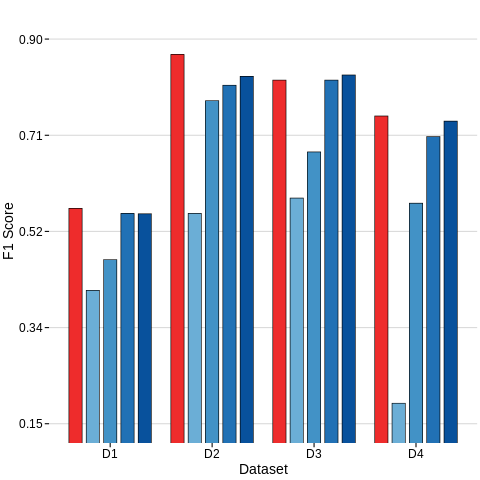

In [7]:
%%R -i pkt_vs_flow_df_melted
motivation_plot <- create_bar_plot(
    pkt_vs_flow_df_melted,
    y_breaks=seq(from = 0.15, to = 0.9, length.out = 5),
    y_limits=c(0.15, 0.9),
    legend_position=c(-0.1, 1.15)
)

motivation_plot

In [8]:
%%R
# save the ggplot with a tight layout around all the components
ggsave(
    motivation_plot, 
    width=5.0, 
    height=1.8, 
    file="/home/jovyan/work/plots/generated/motivation-pkt-vs-flow-level.pdf"
)

In [9]:
%%R 
create_custom_bar_plot <- function(
    this_df,
    y_breaks=seq(from = 0, to = 1, length.out = 5),
    y_limits=c(0.0, 1.0),
    legend_position=c(0.0, 0.8)
    ) {
    
    reds = brewer.pal(n = 9, "Reds")[3:7]
    blues = brewer.pal(n = 9, "Blues")[5:9]
    motivation_palette = c('firebrick2', blues[0], blues[1], blues[2], blues[3], blues[4])

    # bring baselines in order
    datasets_order <- c('D1', 'D2', 'D3', 'D4')
    levels_order <- c('flow_level', 'pkt_level', 'top_k', 'top_k_more', 'SpliDT')
    new_legend_labels <- c("Ideal", "Per Packet", "Flow (Top-K)", "Flow (Top-K)++", "SpliDT")

    # Define custom spacing offsets for each series (level) within each dataset
    offsets <- c(-0.33, -0.18, 0, 0.15, 0.33)  # Adjust these values for custom spacing
    
    # Map the levels to offsets
    this_df <- this_df %>%
        mutate(
            dataset_with_offsets = as.numeric(factor(dataset)) + offsets[match(level, levels_order)],
            level = factor(level, levels = levels_order)
        )
    
    # Plot with modified x-values
    this_bar_plot <- ggplot(this_df, aes(x=dataset_with_offsets, y=f1_score, fill=level)) +
        geom_bar(stat="identity", position="identity", width=0.12, color='black', size=0.3) +
        scale_x_continuous(
            breaks = 1:length(unique(this_df$dataset)),  # Keep original dataset labels
            labels = unique(this_df$dataset)
        ) +
        labs(x = "Dataset", y = "F1 Score") +
        scale_y_continuous(
            breaks = y_breaks, 
            labels = scales::number_format(accuracy = 0.01)
        ) +
        coord_cartesian(ylim = y_limits) +
        theme_hc(base_size = 22) +
        theme(axis.ticks = element_line(color = "black"), 
              axis.ticks.length = unit(0.15, "cm"),
              plot.title = element_text(hjust = 0.5),
              axis.text.x = element_text(colour="black", size=12),
              axis.text.y = element_text(colour="black", size=12),
              axis.title.x = element_text(colour="black", size=14),
              axis.title.y = element_text(colour="black", size=14),
              plot.margin = margin(7, 1, 1, 1, "mm"),
              legend.margin = margin(t = -10.5, r = 0, b = 0, l = 0, unit = "pt"),
              legend.key.width = unit(0.8, "lines"),
              legend.key.height = unit(0.8, "lines"),
              legend.spacing.x = unit(0.1, "cm"),
              legend.spacing.y = unit(0.1, "cm"),
              legend.text=element_text(colour="black", size=12),
              legend.title = element_blank(), 
              legend.position = legend_position,
              legend.justification = c(0, 1)) +
        guides(fill=guide_legend(nrow=1, byrow=TRUE, title=NULL)) +
        scale_fill_manual(values = motivation_palette, labels = new_legend_labels)

    return(this_bar_plot)
}


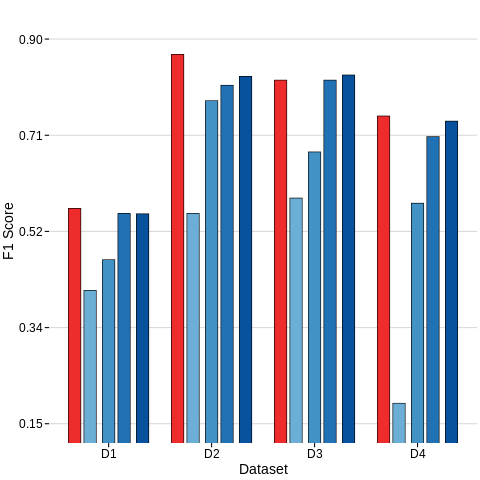

In [10]:
%%R -i pkt_vs_flow_df_melted

custom_motivation_plot <- create_custom_bar_plot(
    pkt_vs_flow_df_melted,
    y_breaks=seq(from = 0.15, to = 0.9, length.out = 5),
    y_limits=c(0.15, 0.9),
    legend_position=c(-0.1, 1.15)
)
custom_motivation_plot

In [11]:
%%R
# save the ggplot with a tight layout around all the components
ggsave(
    custom_motivation_plot, 
    width=5.0, 
    height=1.8, 
    file="/home/jovyan/work/plots/generated/motivation-custom-pkt-vs-flow-level.pdf"
)

# Motivation Pareto Plot

In [12]:
e2e_pareto_path = "csv/e2e-pareto-dataframes"

pareto_cic_iomt_2024_df = pd.read_csv(os.path.join(e2e_pareto_path, "pareto_cic_iomt_2024_df.csv"))
pareto_cic_iot_2023_df = pd.read_csv(os.path.join(e2e_pareto_path, "pareto_cic_iot_2023_df.csv"))
pareto_iscxvpn2016_df = pd.read_csv(os.path.join(e2e_pareto_path, "pareto_iscxvpn2016_df.csv"))

In [13]:
pareto_cic_iomt_2024_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc
0,netbeacon,0,0.430000,0,0,7,65536,0,6,948,948.0,37748736.0,30.00
1,netbeacon,0,0.430000,0,0,7,98304,0,6,948,948.0,37748736.0,30.00
2,netbeacon,0,0.430000,0,0,7,196608,0,6,948,948.0,37748736.0,30.00
3,netbeacon,0,0.430000,0,0,7,262144,0,5,1267,1267.0,62914560.0,50.00
4,netbeacon,0,0.430000,0,0,7,294912,0,5,1267,1267.0,62914560.0,50.00
5,netbeacon,0,0.430000,0,0,7,393216,0,5,1267,1267.0,62914560.0,50.00
6,netbeacon,0,0.380000,0,0,10,491520,0,2,5517,5517.0,31457280.0,25.00
7,netbeacon,0,0.180000,0,0,3,589824,0,2,86,86.0,50331648.0,40.00
8,netbeacon,0,0.180000,0,0,3,688128,0,2,86,86.0,50331648.0,40.00
9,netbeacon,0,0.180000,0,0,3,786432,0,2,86,86.0,50331648.0,40.00


## Average Top-K Plot

In [14]:
# Load your dataframe (assuming it's named df)
def top_k_averager(this_df):
    # Filter only 'leo' and 'netbeacon'
    df_filtered = this_df[this_df['name'].isin(['leo', 'netbeacon'])]

    # Compute the average F1 score for each unique num_flows
    top_k = df_filtered.groupby('num_flows', as_index=False).agg({'f1_score': 'mean'})

    # Add a new category name 'top_k'
    top_k['name'] = 'top_k'

    # Fill other columns with NaN or appropriate default values
    for col in this_df.columns:
        if col not in top_k.columns:
            top_k[col] = None  # Fill missing columns with NaN

    # Reorder columns to match the original dataframe
    top_k = top_k[this_df.columns]

    # Append to the original dataframe
    this_df = pd.concat([this_df, top_k], ignore_index=True)
    
    # pick only rows with name in ['cap', 'top_k']
    this_df = this_df[this_df['name'].isin(['cap', 'top_k'])]
    
    # pick only columns 'name', 'num_flows', 'f1_score'
    this_df = this_df[['name', 'num_flows', 'f1_score']]
    
    return this_df

In [15]:
top_k_pareto_cic_iomt_2024_df = top_k_averager(pareto_cic_iomt_2024_df)
top_k_pareto_cic_iot_2023_df = top_k_averager(pareto_cic_iot_2023_df)
top_k_pareto_iscxvpn2016_df = top_k_averager(pareto_iscxvpn2016_df)

top_k_pareto_iscxvpn2016_df

,name,num_flows,f1_score
24,cap,65536,0.829306
25,cap,98304,0.829306
26,cap,196608,0.829306
27,cap,262144,0.829306
28,cap,294912,0.829306
29,cap,393216,0.814370
30,cap,491520,0.732228
31,cap,589824,0.580687
32,cap,688128,0.580687
33,cap,786432,0.580687


In [16]:
%%R
create_pareto_plot <- function(
    pareto_df, 
    line_size=1,
    point_size=2,
    x_label="#Flows", 
    y_label="F1 Score",
    y_title=element_blank(),
    tag, 
    # x_breaks=seq(from=0, to=1000000, length.out=4),
    x_breaks=c(0, 100000, 500000, 1000000),
    y_breaks,
    y_limits,
    h_lines = c(0.2, 0.5),
    # h_line_colors = c("#C00000", "#7030A0"),
    h_line_colors = c("#7030A0"),
    legend_position="none"
    ) {

    blues = brewer.pal(n = 9, "Blues")[5:9]
    reds = brewer.pal(n = 9, "Reds")[4:8]

    pareto_color_palette <- c(reds[4], blues[3])
    new_legend_labels <- c("Top-k", "SpliDT")

    # Reorder 'name' column to order netbeacon -> leo -> cap
    pareto_df$name <- factor(pareto_df$name, levels = c("top_k", "cap"))

    pareto_plot <- ggplot(pareto_df, aes(x=num_flows, y=f1_score, color=name)) +
                          geom_line(size=line_size) +
                          geom_point(size=point_size) +
                          labs(x = x_label, y = y_label, tag = tag) +
                          scale_x_continuous(breaks=x_breaks, labels = label_number_si()) +
                          scale_y_continuous(breaks=y_breaks, labels = scales::number_format(accuracy = 0.01)) +
                          coord_cartesian(ylim = y_limits) +
                          theme_hc(base_size = 22) +
                          theme(axis.ticks = element_line(color = "black"), # Ensure ticks are visible
                                axis.ticks.length = unit(0.15, "cm"), # Adjust the length of the ticks as needed
                                plot.title = element_text(hjust = 0.5),
                                axis.text.x=element_text(colour="black", size=16),
                                axis.text.y=element_text(colour="black", size=16),
                                axis.title.x=element_text(colour="black", size=18),
                                axis.title.y=y_title,
                                legend.text=element_text(size=16),
                                plot.tag=element_text(colour="black", size=18, angle=0,
                                                      margin=margin(t=-10, r=0, b=0, l=0, unit="pt"),
                                                      vjust=2.0),
                                plot.tag.position = "top") +
                          guides(fill=guide_legend(ncol=1, bycol=TRUE, title=NULL), linetype=FALSE) +
                          theme(plot.margin = margin(0.6, 0.25, 0.1, 0.25, "cm"),
                                legend.margin = margin(t = -10.5, r = 0, b = 0, l = 0, unit = "pt"),
                                legend.key.width = unit(0.4, "lines"),
                                legend.key.height = unit(0.4, "lines"),
                                legend.spacing.x = unit(0.05, "cm"),
                                legend.spacing.y = unit(0.05, "cm"),
                                legend.title = element_blank(), 
                                legend.position = legend_position, 
                                legend.justification = c(0, 1)) +
                          scale_color_manual(values = pareto_color_palette, labels = new_legend_labels)
                          
    # # Add horizontal lines if provided
    # if (!is.null(h_lines)) {
    #     pareto_plot <- pareto_plot + 
    #         geom_hline(yintercept = h_lines[1], linetype = "dotted", color = h_line_colors[1], size = 0.6, alpha=0.7) +
    #         geom_hline(yintercept = h_lines[2], linetype = "dotted", color = h_line_colors[2], size = 0.6, alpha=0.7)
    # }
    
    # Add horizontal lines if provided
    if (!is.null(h_lines)) {
        pareto_plot <- pareto_plot + 
            geom_hline(
                yintercept = h_lines[1], linetype = "dashed", 
                color = h_line_colors[1], size = 0.6, alpha=0.9
            ) + 
            geom_hline(
                yintercept = h_lines[2], linetype = "dashed", 
                color = h_line_colors[2], size = 0.6, alpha=0.9
            )
    }
    
    return (pareto_plot)
}

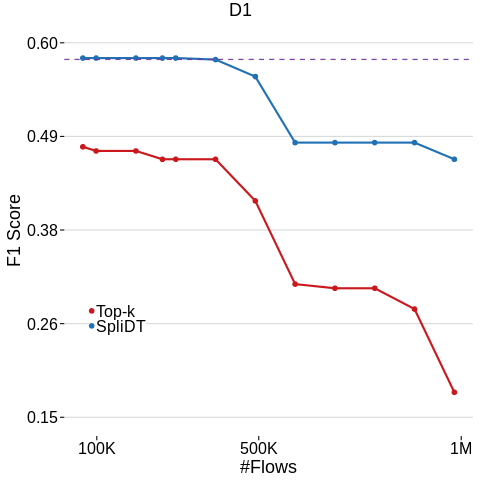

In [17]:
%%R -i top_k_pareto_cic_iomt_2024_df
top_k_pareto_cic_iomt_2024_plot <- create_pareto_plot(
    pareto_df=top_k_pareto_cic_iomt_2024_df, 
    # h_lines = c(0.41, 0.58),  # Horizontal lines at y=0.8 and y=0.9
    h_lines = c(0.58),
    tag="D1", 
    y_title=element_text(colour="black", size=18),
    y_breaks=seq(from=0.15, to=0.60, length.out=5),
    y_limits=c(0.15, 0.60),
    legend_position=c(0.06, 0.30)
)
top_k_pareto_cic_iomt_2024_plot

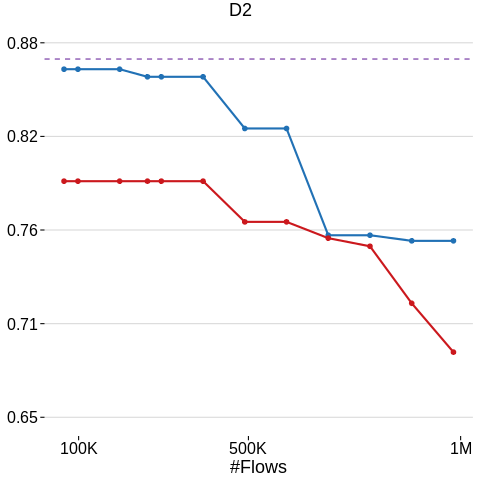

In [18]:
%%R -i top_k_pareto_cic_iot_2023_df
top_k_pareto_cic_iot_2023_plot <- create_pareto_plot(
    pareto_df=top_k_pareto_cic_iot_2023_df, 
    # h_lines = c(0.56, 0.87),  # Horizontal lines at y=0.8 and y=0.9
    h_lines = c(0.87),  # Horizontal lines at y=0.8 and y=0.9
    tag="D2", 
    y_breaks=seq(from=0.65, to=0.88, length.out=5),
    y_limits=c(0.65, 0.88)
)
top_k_pareto_cic_iot_2023_plot

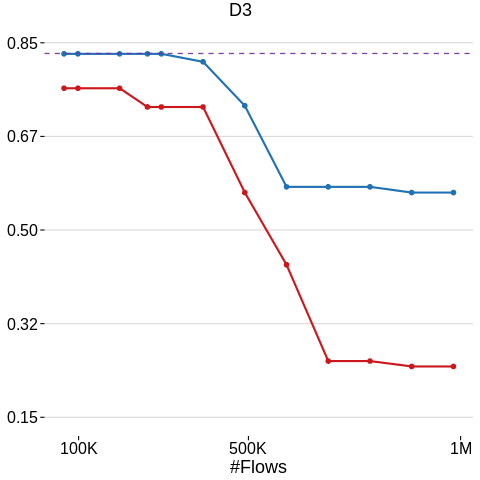

In [19]:
%%R -i top_k_pareto_iscxvpn2016_df
top_k_pareto_iscxvpn2016_plot <- create_pareto_plot(
    pareto_df=top_k_pareto_iscxvpn2016_df, 
    # h_lines = c(0.59, 0.82),  # Horizontal lines at y=0.8 and y=0.9
    # h_lines = c(0.82),  # Horizontal lines at y=0.8 and y=0.9
    h_lines = c(0.83),  # bump Oracle to CaP
    tag="D3", 
    y_breaks=seq(from=0.15, to=0.85, length.out=5),
    y_limits=c(0.15, 0.85)
)
top_k_pareto_iscxvpn2016_plot

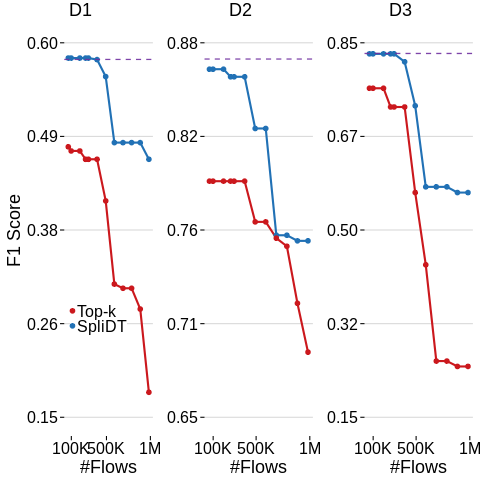

In [20]:
%%R
# save the ggplot with a tight layout around all the components
top_k_combined_pareto_plots <- grid.arrange(
    top_k_pareto_cic_iomt_2024_plot,
    top_k_pareto_cic_iot_2023_plot,
    top_k_pareto_iscxvpn2016_plot,
    nrow=1
)
ggsave(
    top_k_combined_pareto_plots, 
    width=8.8, height=2.5, 
    file="/home/jovyan/work/plots/generated/motivation_top_k_pareto.pdf"
)